# UQ analysis

This notebook is used to run UQ analysis on the model by using MonteCarlo Dropout and Parameter Estimation methods.

In [3]:
import glob
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from obspy.core import Stream, Stats, Trace
from torch.utils import data
from torch_utils import *
from tqdm import tqdm
import torch.distributions as dd
from utils import *
%config InlineBackend.figure_formats = ['svg']


## Loading data

Select paths where pre-computed models and data are stored

In [16]:
testing_data_path = '../data/testing/data_su/'
model_path_dropout = 'model_dropout.pt'
model_path_DPE = 'model_deepEnsembles.pt'

synwav = np.load('../data/wavelet.npy')

Other parameters for data preprocessing and to compute dispersion panels for visualization purposes

In [17]:
# total depth
sizez = 50

# receiver axis
nx = 24
dx = 1
ox = 15

# time axis
t0 = 0.23
dt = 0.0005
nt = 1999

# velocities and frequencies for dispersion panels
#cmin = 0
#cmax = 1500
cmin = 5
cmax = 2000
dc = 1.0
fmin = 5
fmax = 70
nperiod = 500 # number of samples in period/freq axis

x = np.arange(nx)*dx + ox
t = np.arange(nt)*dt
freq_fm = np.linspace(fmin, 60, nperiod)
period = np.linspace(1/60, 0.2, nperiod)

Load field data

In [19]:
set_seed(40)
idx = [-1, -2]
testing_data = []
testing_label = []
up = []
num_testing = 25

for m in np.random.randint(0, 25, num_testing):
    filename = str(m) + '_rvz.su'
    traces = read(testing_data_path + filename)

    for tt in range(len(traces)):
        traces[tt].data = cn(traces[tt].data, 3)  # add noise

        traces[tt] = traces[tt].trim(
            traces[tt].stats.starttime + t0, traces[tt].stats.starttime + t0 + 0.4)  # adjust time axis

    u = traces[0:len(traces)]
    unp = np.zeros((len(u), u[0].stats.npts), dtype='float32')

    for uu in range(len(u)):
        unp[uu] = u[uu].data
    up.append(u)
    testing_data.append(np.delete(unp, idx, 1))

In [20]:
# Normalize
testing_data_norm = []
for k in range(len(testing_data)):
    testing_d_norm = testing_data[k] / \
        testing_data[k].max(axis=1)[:, np.newaxis]
    testing_data_norm.append(testing_d_norm)


(-0.5, 24.5, 798.5, -0.5)

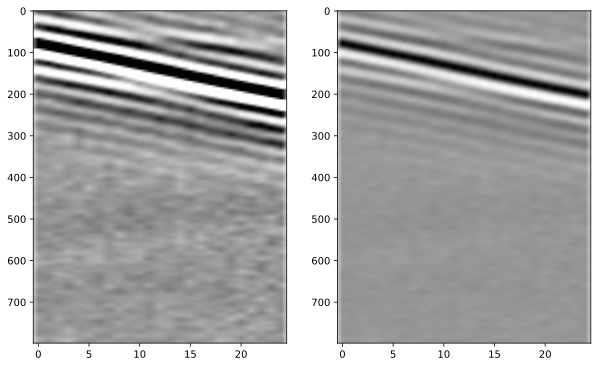

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
value = 10
axs[0].imshow(testing_data[value].T, cmap='Greys', norm = getnorm(testing_data[value], 4), interpolation='none')
axs[0].axis('tight')
axs[1].imshow(testing_data_norm[value].T, cmap='Greys', norm=getnorm(testing_data_norm[value].T), interpolation='none')
axs[1].axis('tight')

## Inference

Prepare data for torch inference

In [24]:
testing_data_tensor = torch.Tensor(testing_data_norm)
testing_data_tensor = testing_data_tensor.reshape(testing_data_tensor.shape[0], 1, 
                                                  testing_data_tensor.shape[1], 
                                                  testing_data_tensor.shape[2])
testing_dataset = data.TensorDataset(testing_data_tensor)

batch_size = 1
testing_loader = data.DataLoader(dataset=testing_dataset, batch_size=batch_size, num_workers=0)

Perform inference

In [25]:
device = torch.device('cpu')
model_dropout = torch.load(model_path_dropout).to(device)
model_dropout.eval()
model_dropout.fc.train()

model_dpe = torch.load(model_path_DPE).to(device)
model_dpe.eval()
model_dpe.fc.train()

outputs_dropout_list = []
outputs_dpe_list = []

for bs, (shot_gathers) in enumerate(tqdm(testing_loader)):
    i = 0
    outputs_dropout = []
    outputs_dpe = []

    while i < 100:
        output_dropout = model_dropout(shot_gathers[0])
        outputs_dropout.append(output_dropout.detach().numpy())

        i = i + 1

    output_dpe = model_dpe(shot_gathers[0])
    outputs_dpe.append(output_dpe.detach().numpy())

    outputs_dropout_list.append(outputs_dropout)
    outputs_dpe_list.append(outputs_dpe)


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


In [27]:
outputs_dpe_nparray = np.zeros((129, 1000))
count = 0

for l in range(len(outputs_dpe_list)):
    for ll in range(len(outputs_dpe_list[l])):
        if l == 0:
            count = ll
            #print(count)
            #np.save(str(count) + '_prediction.npy',outputs_list[l][ll])
            outputs_dpe_nparray[count] = outputs_dpe_list[l][ll]
        else:
            count = count + 1
            #print(count)
            #np.save(str(count) + '_prediction.npy',outputs_list[l][ll])
            outputs_dpe_nparray[count] = outputs_dpe_list[l][ll]

In [28]:
ntmax = testing_data_norm[0].shape[1]
stats = Stats()
stats.starttime = 0.23
stats.delta = 0.0005
stats.npts = ntmax
up2 = []

for i in range(len(testing_data_norm)):
    stream = Stream()

    for j in range(testing_data_norm[i].shape[0]):
        stream.append(Trace(data=testing_data_norm[i][j].astype(np.float32), header=stats))
    up2.append(stream)


Display preditions

0
dt:  0.0005
nt:  801
Frequency resolution up to 70.00 kHz: 28 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
1
dt:  0.0005
nt:  801
Frequency resolution up to 70.00 kHz: 28 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
2
dt:  0.0005
nt:  801
Frequency resolution up to 70.00 kHz: 28 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
3
dt:  0.0005
nt:  801
Frequency resolution up to 70.00 kHz: 28 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins
4
dt:  0.0005
nt:  801
Frequency resolution up to 70.00 kHz: 28 bins
Phase velocity resolution up to 2000.00 m/s: 1995 bins


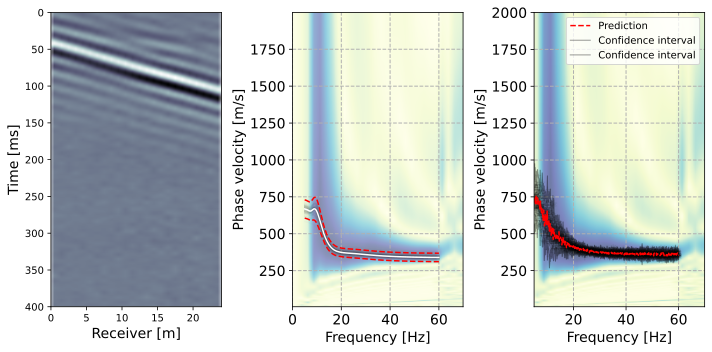

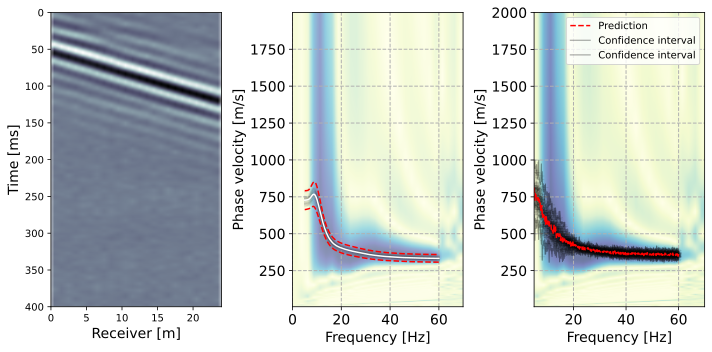

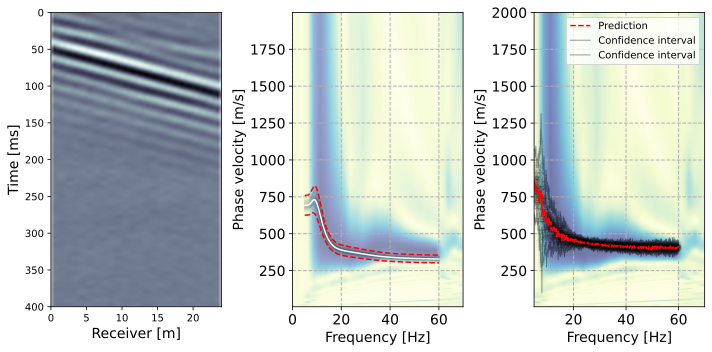

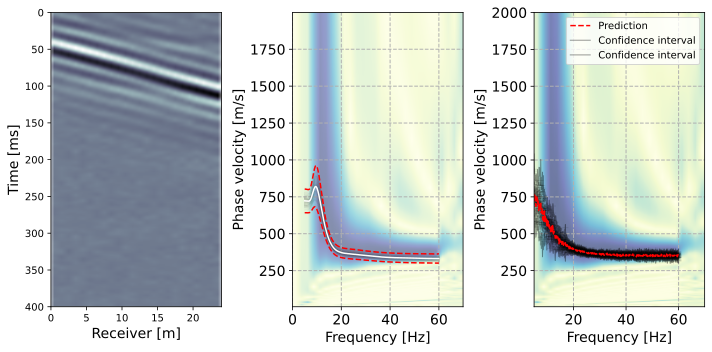

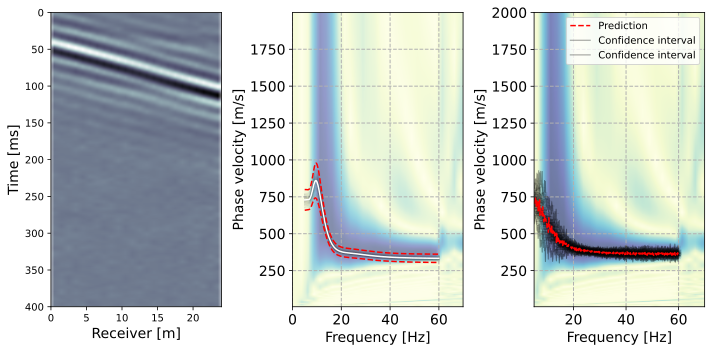

In [30]:
for n in range(5):
    print(n)
    u2 = up[n]
    data_su = np.array([u2[i].data for i in range(len(u2))]).T
    data_su = data_su[:, :nx]
    
    ## phase shift method
    f,c,img,fmax_idx,U,t = get_dispersion(u2.copy(),dx,cmin,cmax,dc,fmax)
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    clip = 1e0
    axs[0].imshow(data_su, cmap='bone', norm=getnorm(data_su), interpolation='none', extent=(0, 24, 400, 0))
               #extent=(x[0], x[-1], t[-1], t[0]))
    axs[0].axis('tight')
    axs[0].set_xlabel('Receiver [m]', fontsize=14)
    axs[0].set_ylabel('Time [ms]', fontsize=14)

    cax = axs[1].imshow(img[:,:],aspect='auto',origin='lower',cmap='YlGnBu',extent=(f[0],f[fmax_idx],c[0],c[-1]),interpolation='bilinear', alpha=0.5)
    axs[1].grid(linestyle='--',linewidth=1)
    c_line = np.zeros(fmax_idx)
    for fi in range(fmax_idx):
        cmax_idx =np.argmax(img[:,fi])
        c_line[fi] = c[cmax_idx]
    axs[1].set_xlabel('Frequency [Hz]', fontsize=14)
    axs[1].set_ylabel('Phase velocity [m/s]', fontsize=14)
    axs[1].tick_params(axis = 'both', which = 'major', labelsize = 14)
    axs[1].tick_params(axis = 'both', which = 'minor', labelsize = 14)

    array = np.stack(outputs_dropout_list[n])
    estd = np.std(array, axis=0).squeeze()

    for i in array:
        axs[1].plot(freq_fm, i.squeeze(), c='k', alpha=0.017)

    axs[1].plot(freq_fm, np.mean(array, axis=0).squeeze(), 'w', label='Mean inference')
    axs[1].plot(freq_fm, np.mean(array, axis=0).squeeze() + 2.5*estd, 'r--', label='Confidence interval')
    axs[1].plot(freq_fm, np.mean(array, axis=0).squeeze() - 2.5*estd, 'r--')

    cax = axs[2].imshow(img[:,:],aspect='auto',origin='lower',cmap='YlGnBu',extent=(f[0],f[fmax_idx],c[0],c[-1]),alpha=0.6,interpolation='bilinear')
    axs[2].grid(linestyle='--',linewidth=1)
    axs[2].set_xlabel('Frequency [Hz]', fontsize=14)
    axs[2].set_ylabel('Phase velocity [m/s]', fontsize=14)
    axs[2].tick_params(axis = 'both', which = 'major', labelsize = 14)
    axs[2].tick_params(axis = 'both', which = 'minor', labelsize = 14)

    yest = torch.from_numpy(np.array(outputs_dpe_nparray)[n])

    mu, sig = yest[:500], torch.exp(yest[500:])
    ydistr = dd.Normal(mu, sig)
    yreals = ydistr.sample((10,)).T
    ypred = yreals.mean(axis=1)
    ystd = yreals.std(axis=1)

    axs[2].plot(freq_fm, yreals.cpu().numpy(), '+k', alpha=0.09)
    axs[2].plot(freq_fm, ypred.cpu().numpy(), 'r--', label='Prediction')
    axs[2].plot(freq_fm, ypred.cpu().numpy()+2.5*ystd.cpu().numpy(), 'k', alpha=0.4, linewidth=1, label='Confidence interval')
    axs[2].plot(freq_fm, ypred.cpu().numpy()-2.5*ystd.cpu().numpy(), 'k', alpha=0.4, linewidth=1, label='Confidence interval')

    plt.xlim((fmin,f[fmax_idx]))
    plt.ylim((cmin,cmax))
    plt.legend(frameon=True)
    plt.tight_layout()